In [25]:
%matplotlib notebook

from collections import Counter
import json
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from imgaug import augmenters as iaa
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from pycocotools.coco import COCO
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

from abyss_deep_learning.keras.classification import (
    ClassificationDataset, caption_map_gen, onehot_gen, augmentation_gen, PRTensorBoard)
from abyss_deep_learning.keras.utils import batching_gen, lambda_gen
import abyss_deep_learning.abyss_dataset as dataset_model

# Setup Data

In [40]:
############### CONFIGURE THIS ########################
# num_classes assumed from caption_map entries
image_dims = (299, 299, 3) # Preset for InceptionV3
batch_size = 5
log_dir = "/data/log/cnn/fd/lr0.5e-4_patience-9"

# maps caption strings to class numbers (ensure minimal set of class numbers)
# eg use {0, 1, 2} not {4, 7, 8}

# Caption type can be either "single" or "multi".
# This sets up various parameters in the system.
# If conversion between single and multi is required this should be done explicitly and presented
# in a separate json file. The internal representation of all the labels is one-hot encoding.
caption_type = "multi" 
caption_map = {
    'IP': 1,
    'JD_ML': 0
}
coco_train = ClassificationDataset(caption_map, "/data/abyss/projectmax/feature-detection/training2-ip-jdml.json")
coco_val = ClassificationDataset(caption_map, "/data/abyss/projectmax/feature-detection/validation2-ip-jdml.json")
coco_test = ClassificationDataset(caption_map, "/data/abyss/projectmax/feature-detection/validation2-ip-jdml.json")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [41]:
# # Convert instances to categories
# from abyss_deep_learning.coco_classes import CocoDataset
# ds = CocoDataset.from_COCO(coco_val)
# ds.convert_instances_to_captions()
# ds.save("/data/abyss/projectmax/feature-detection/validation2-ip-jdml.json")

In [42]:
caption_map_r = {val: key for key, val in caption_map.items()}
num_classes = len(caption_map)
steps_per_epoch = coco_train.num_images() // batch_size
steps_per_epoch_val = coco_val.num_images() // batch_size
print("Number of classes:", num_classes)
print("Steps per epoch:", steps_per_epoch)
print("Steps per steps_per_epoch_val:", steps_per_epoch_val)

Number of classes: 2
Steps per epoch: 33
Steps per steps_per_epoch_val: 10


In [43]:
def preprocess(image, caption):
    image = resize(image, image_dims, preserve_range=True)
    return preprocess_input(image.astype(np.float32)), caption

def postprocess(image):
    return ((image + 1) * 127).astype(np.uint8)

def pipeline(gen, aug_config=None):
    return (
        augmentation_gen(
            onehot_gen(
                lambda_gen(
                    caption_map_gen(gen, caption_map)
                , func=preprocess)
            , num_classes=num_classes)
        , aug_config, enable=(aug_config is not None))
    )

def augmentation_gen(gen, aug_config, enable=True):
    '''
    Data augmentation for classification task.
    Target is untouched.
    '''
    if not enable:
        while True:
            yield from gen
    aug_list = []
    if 'flip_lr_percentage' in aug_config:
        aug_list += [iaa.Fliplr(aug_config['flip_lr_percentage'])]
    if 'flip_ud_percentage' in aug_config:
        aug_list += [iaa.Flipud(aug_config['flip_ud_percentage'])]
    if 'affine' in aug_config:
        aug_list += [iaa.Affine(**aug_config['affine'])]
#     if 'color' in aug_config: #  Color aug not working  yet
#         aug_list += [iaa.Sometimes(
#             aug_config['color']['probability'], iaa.Sequential([
#             iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
#             iaa.WithChannels(0, iaa.Add(aug_config['color']['hue'])),
#             iaa.WithChannels(1, iaa.Add(aug_config['color']['saturation'])),
#             iaa.WithChannels(2, iaa.Add(aug_config['color']['value'])),
#             iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")
#         ]))]
    seq = iaa.Sequential(aug_list)
    for image, target in gen:
        yield seq.augment_image(image), target
        
aug_config = {
    'flip_lr_percentage': 0.5,
    'flip_ud_percentage': 0.5,
    'affine': {
        "order": 1,
        'scale': {
            "x": (0.8, 1.2),
            "y": (0.8, 1.2)
        },
        "rotate": (-10, 10),
        "shear": (-5, 5),
        "mode": 'constant'
    },
#     'color': {
#         'probability': 1.00,
#         'hue': (0, 0),
#         'saturation': (0, 0),
#         'value': (0, 0)
#     }
}


(299, 299, 3) [1 0]
(299, 299, 3) [1 0]
(299, 299, 3) [1 0]


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<IPython.core.display.Javascript object>


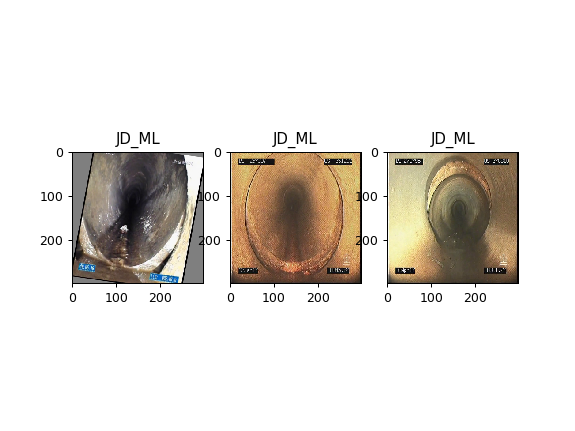

Left to right: ground truth samples from train, val test


In [44]:
train_gen = pipeline(
    coco_train.generator(shuffle_ids=True),
    aug_config=aug_config)
val_gen = pipeline(coco_val.generator(shuffle_ids=True))
test_gen = pipeline(coco_test.generator(shuffle_ids=True))
    
for i, (train, val, test) in enumerate(zip(train_gen, val_gen, test_gen)):
    print(train[0].shape, train[1])
    print(val[0].shape, val[1])
    print(test[0].shape, test[1])
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(postprocess(train[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(train[1])]))
    
    plt.subplot(1, 3, 2)
    plt.imshow(postprocess(val[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(val[1])]))
    
    plt.subplot(1, 3, 3)
    plt.imshow(postprocess(test[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(test[1])]))
    
    if i >= 0:
        break
print("Left to right: ground truth samples from train, val test")        

In [34]:
def gen_dump_data(gen, num_images):
    data = [[],[]]
    for i, (image, caption) in enumerate(gen):
        data[0].append(image)
        data[1].append(caption)
        if i >= num_images:
            break
    data = (
        np.concatenate([i[np.newaxis, ...] for i in data[0]], axis=0),
        np.concatenate([i[np.newaxis, ...] for i in data[1]], axis=0)
    )
    return data

def count_labels_multi(data):
    return Counter([int(j) for i in data[1] for j in np.argwhere(i)])

In [45]:
train_data = gen_dump_data(train_gen, coco_train.num_images())
val_data = gen_dump_data(val_gen, coco_val.num_images())
test_data = gen_dump_data(test_gen, coco_test.num_images())

for label, data in zip(
        ["train", "val", "test"],
        [train_data, val_data, test_data]):
    counter = count_labels_multi(data)
    print(label, counter)
    
train_counts = count_labels_multi(train_data)
class_weights =  1 / np.array([j for i, j in sorted(train_counts.items(), key=lambda x: x[0])], dtype=np.float32)
class_weights /= np.linalg.norm(class_weights)
class_weights = dict(zip(sorted(train_counts.keys()), class_weights.tolist()))
print("class_weights:")
print(class_weights)
del train_data

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


train Counter({0: 105, 1: 68})
val Counter({0: 31, 1: 24})
test Counter({0: 31, 1: 24})
class_weights:
{0: 0.5435827374458313, 1: 0.8393556475639343}


# Setup model

In [46]:
def create_new_head(base_model, num_classes, caption_type, train_features=False, opt_params={}):
    '''make sure base_model has include_top=False'''
    from keras.layers import Dense, MaxPooling2D, Dropout, Flatten
    from keras.models import Model
    
    if not opt_params:
        opt_params = {"optimizer": "Nadam"}
    opt_params['loss'] = "categorical_crossentropy" if caption_type == "single" else "binary_crossentropy"
    activation = "softmax" if caption_type == "single" else "sigmoid"
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation=activation, name='class_logits')(x)


    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = train_features
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(**opt_params, metrics=['accuracy'])
    return model

In [47]:
### Note:
###    When single-label training a 'softmax' activation and 'categorical_crossentropy' loss is used
###    When multi-label training a 'sigmoid' activation and 'binary_crossentropy' loss is used

K.clear_session()
model = create_new_head(
    InceptionV3(
        include_top=False, weights='imagenet', input_shape=image_dims),
    num_classes, caption_type, train_features=True,
    opt_params={'optimizer': "Nadam"})

# Train model

In [48]:
### Load model weights if needed
# model.load_weights("/data/log/cnn/cso-sigmoid/models/best.058-0.0681.h5")
# model.load_weights("/data/log/cnn/cso/models/best.036-0.1494.h5")

In [49]:
best_path = os.path.join(log_dir, "models/best.{epoch:03d}-{val_loss:.4f}.h5")

callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=9, cooldown=6, verbose=1),
        ModelCheckpoint(
            best_path, monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=True, mode='auto', period=1),
        PRTensorBoard(log_dir=log_dir,
                     histogram_freq=0,
            batch_size=batch_size,
            write_graph=False,
            write_grads=False,
            write_images=False),
#         EarlyStopping(
#             monitor='val_loss', min_delta=0.0, patience=40, verbose=1, mode='auto')
]


In [ ]:
# Train with initial LR
learning_rate = 1e-4
K.set_value(model.optimizer.lr, learning_rate)
train_history = model.fit_generator(
    batching_gen(train_gen, batch_size=batch_size),
    validation_data=tuple(val_data),
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    class_weight=class_weights,
    callbacks=callbacks, 
    epochs=200,
    verbose=1)

Epoch 1/200


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


33/33 [==============================] - 10s 295ms/step - loss: 0.9680 - acc: 0.5606 - val_loss: 0.9484 - val_acc: 0.5636

Epoch 00001: val_loss improved from inf to 0.94837, saving model to /data/log/cnn/fd/lr0.5e-4_patience-9/models/best.001-0.9484.h5


# Model Testing

In [ ]:
def multi_label_decision(y_true, y_pred, thresh=0.5):
    return (y_true > thresh) == (y_pred > thresh)
def single_label_decision(y_true, y_pred):
    return np.argmax(y_true, axis=-1) == np.argmax(y_pred, axis=-1)

decision_function = single_label_decision if caption_type == 'single' else multi_label_decision
thresh = 0.5 # Used for multi-label decisions

Y_true = test_data[1]
Y_pred = model.predict(test_data[0])
TP = decision_function(Y_true, Y_pred)
print("Test accuracy for {:d} samples: {:.2f}".format(len(test_data[0]), np.count_nonzero(TP) / TP.size))
for i, (image, true_caption, pred_caption) in enumerate(zip(test_data[0], test_data[1], Y_pred)):
    if i % 4 == 0:
        if i > 0:
            plt.tight_layout()
        if i >= 4:
            break
        if i < len(test_data[0]):
            plt.figure()
    plt.subplot(2, 2, 1 + (i % 4))
    plt.imshow(postprocess(image))
    plt.title("T: {:s}; P: {:s}".format(
        ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(true_caption > thresh)]),
        ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(pred_caption > thresh)])
    ))
test_metrics = model.evaluate(test_data[0], test_data[1]);

# Save model (pretty important!)

In [ ]:
def save_model(model, name, class_map_r, prediction_type,
               model_weights_path, model_def_path, model_info_path,
               test_metrics=None, description=""):
    def merged(a, b):
        merged = dict(a)
        merged.update(b)
        return merged
        
    model_info = {
        "name": name,
        "description": description,
        "weights": model_weights_path,
        "prediction_type": caption_type,
        "model": model_def_path,
        "classes": class_map_r,
        "architecture": {
            "backbone": "inceptionv3",
            "logit_activation": model.get_layer("class_logits").activation.__name__,
            "input_shape": image_dims
        },
        "metrics": {
            "loss_function": train_history.model.loss,
            "train": merged(
                train_history.history,
                {
                    "epoch": train_history.epoch,
                    "params": train_history.params
                })
        }
    }
    if test_metrics:
        model_info['metrics']['test'] = test_metrics
    
    print("Writing model def to " + model_def_path)
    with open(model_def_path, "w") as file:
        file.write(model.to_json())
        
    print("Writing model weights to " + model_weights_path)
    model.save_weights(model_weights_path)
    
    print("Writing model info to " + model_info_path)
    with open(model_info_path, "w") as file:
        file.write(json.dumps(model_info))
    
# Fill in the relevant params below    
model_def_path = os.path.join(log_dir, "model_def.json")
model_weights_path = os.path.join(log_dir, "model_weights.h5")
model_info_path = os.path.join(log_dir, "model.json")
save_model(
    model, name="example-1",
    class_map_r=caption_map_r, prediction_type=caption_type,
    model_weights_path=model_weights_path, model_def_path=model_def_path, model_info_path=model_info_path,
    test_metrics=test_metrics,
    description="Model for detecting whether camera is forwards or sidewards facing in a pipe."
)